In [69]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
from datetime import date

def find_start(data):
    start_found=False
    timestamps=data['unix']
    index=len(timestamps)-1
    while not(start_found):
        day=date.fromtimestamp(timestamps.iloc[index]).weekday()
        if day==0:
            start_found=True
        else:
            index=index-1
    return timestamps.iloc[index]

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    start=find_start(raw)
    trimmed=raw.loc[raw['unix']>=start]
    return trimmed.sort_values(by=['unix'], ignore_index=True)

btc_price_data=read_data('Bitstamp_BTCUSD_d.csv')
weekly_candles=price.get_price_data('1w',data=btc_price_data)
# candles=[]
# for i in reversed(range(len(btc_price_data))):
#     candle=btc_price_data.iloc[i]
#     candles.append((candle['unix'],candle['open'], candle['high'],candle['low'], candle['close']))

In [118]:
def get_sma(data,window):
     #using daily for now
    timestamps=data['unix'][window-1:]
    sma=data.rolling(window).mean()['close'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window):
    timestamps=data['unix'][window:]
    ema=data.ewm(span=window, adjust=False).mean()['close']
    ema=ema[window:]
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    start_date=slow['unix'].min()
    trimmed_fast=fast.loc[fast['unix']>=start_date]

    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [111]:
fast=get_sma(btc_price_data,50)
fast_ema=get_ema(btc_price_data,21)
slow=get_sma(weekly_candles,50)



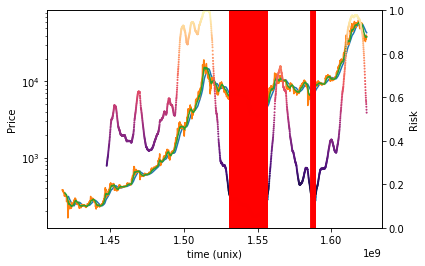

In [115]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(fast,slow)
ax1.plot(btc_price_data['unix'],btc_price_data['close'])
ax1.plot(fast_ema['unix'],fast_ema['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
filtered_risk=risk.loc[risk['value']<0.15]
ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='magma')

(0.0, 1.0)

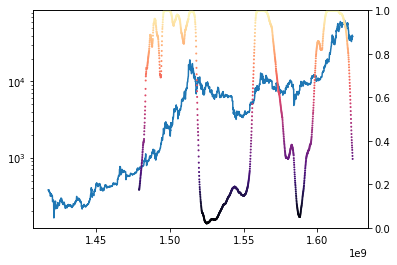

In [136]:


fig2, ax3 = plt.subplots()
ax3.plot(btc_price_data['unix'],btc_price_data['close'])
risk2= rolling_risk(fast,slow,365)
filtered_risk=risk2.loc[risk2['value']>0.9]
ax3.set_yscale('log')
ax4 = ax3.twinx()
ax4.scatter(risk2['unix'],risk2['value'], s=1, c=risk2['value'], cmap='magma')
ax4.set_ylim(0,1)
#ax4.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

In [125]:
def rolling_risk(fast,slow,window):#probably better to use long windows
    start_date=slow['unix'].min()
    trimmed_fast=fast.loc[fast['unix']>=start_date]

    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    moving_average=risk_metric.rolling(window).mean()
    moving_standard_deviation=risk_metric.rolling(window).std()
    df=pd.DataFrame({'unix':trimmed_fast['unix'],'risk_metric':risk_metric})
    df['mean']=moving_average
    df['sigma']=moving_standard_deviation
    df.dropna(inplace=True)
    coded=np.divide(df['risk_metric'].values - df['mean'].values, df['sigma'].values)
    risk=norm.cdf(coded)
    df['value']=risk
    return df

rolling_risk(btc_price_data,slow,100)

,unix,risk_metric,mean,sigma,value
448,1456099200,1.467466,1.448146,0.149952,0.551258
449,1456185600,1.405462,1.450078,0.148115,0.381620
450,1456272000,1.412060,1.451538,0.146999,0.394134
451,1456358400,1.413101,1.452826,0.146079,0.392832
452,1456444800,1.425434,1.454169,0.145193,0.421559
...,...,...,...,...,...
2386,1623542400,1.326365,2.186562,0.633770,0.087348
2387,1623628800,1.371120,2.172462,0.636089,0.103872
2388,1623715200,1.352139,2.157210,0.637302,0.103250
2389,1623801600,1.284575,2.140710,0.638330,0.089926


In [143]:
month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}
def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=string[1]
    year=string[2]
    return (day,month,year)
    
cardano_raw_data=pd.read_csv('data/cardano_2017-10-1_2021-6-24.csv')
cardano_raw_data

parse_data('Jun-22-2021')

22 6 2021
